In [1]:
%load_ext autoreload
%autoreload 2
import os
from encoding_information.gpu_utils import limit_gpu_memory_growth  
limit_gpu_memory_growth()
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

from resolution1d_utils import *
from tqdm import tqdm

2024-04-24 11:00:48.980273: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Rayleigh distance: 400.0 nm


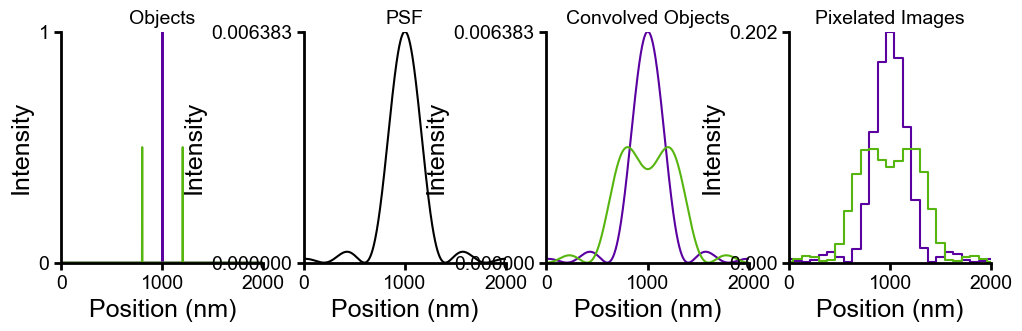

In [2]:
wavelength = 400 # nm
NA = .5
pixel_size = 80 # nm
size = 2000 # nm
num_pixels = int(size / pixel_size)
seperation_distance = 400 # nm

rayleigh_dist = wavelength / (2 * 0.5)
seperation_distance = rayleigh_dist
print(f"Rayleigh distance: {rayleigh_dist} nm")

(one_point_object, two_point_object, one_point_convolved, two_point_convolved, one_point_noiseless_pixels, two_point_noiseless_pixels,
  x, PSF) = simulate_optics(wavelength, NA, size, seperation_distance, pixel_size)


###### Make plots ###### 
# plot both objects
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].plot(x, one_point_object, get_color_cycle()[1])
ax[0].plot(x, two_point_object, get_color_cycle()[3])
ax[0].set(title='Objects', xlim=(x.min(), x.max()), ylim=(0, 1), yticks=[0, 1], xlabel='Position (nm)', ylabel='Intensity')

# plot the PSF
ax[1].plot(x, PSF, 'k-')
ax[1].set(title='PSF', xlim=(x.min(), x.max()), ylim=(0, PSF.max()), yticks=[0, PSF.max()], xlabel='Position (nm)', ylabel='Intensity')

# plot the convolved objects
ax[2].plot(x, one_point_convolved, get_color_cycle()[1])
ax[2].plot(x, two_point_convolved, get_color_cycle()[3])
ax[2].set(title='Convolved Objects', xlim=(x.min(), x.max()), ylim=(0, one_point_convolved.max()), 
          yticks=[0, one_point_convolved.max()], xlabel='Position (nm)', ylabel='Intensity')


# plot pixelated images
ax[3].plot(np.linspace(0, num_pixels * pixel_size, num_pixels), one_point_noiseless_pixels, drawstyle='steps-mid', color=get_color_cycle()[1])
ax[3].plot(np.linspace(0, num_pixels * pixel_size, num_pixels), two_point_noiseless_pixels, drawstyle='steps-mid', color=get_color_cycle()[3])
ax[3].set(title='Pixelated Images', xlim=(0, size), ylim=(0, one_point_noiseless_pixels.max()), 
          yticks=[0, one_point_noiseless_pixels.max()], xlabel='Position (nm)', ylabel='Intensity')

_ = [clear_spines(ax[i]) for i in range(len(ax))]

plt.gcf().savefig('/home/hpinkard_waller/figures/1d_signals/' + f'2_point_intro' + '.pdf', transparent=True)

## Estimate the MI of noisy measurements

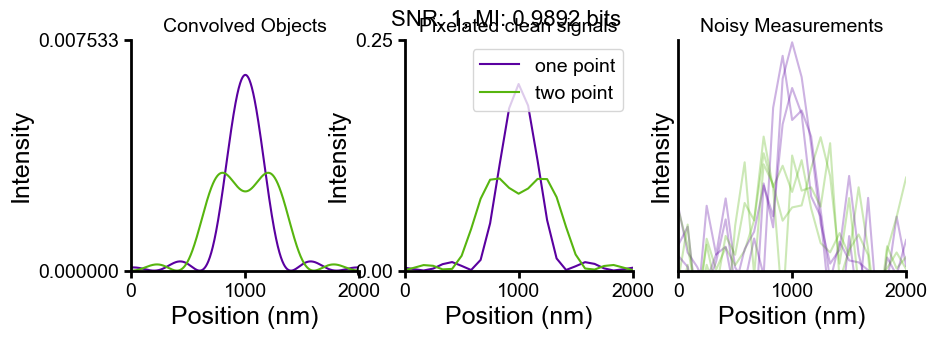

In [3]:
num_measurements = int(1e6)
snr = 1
num_measurements_to_display = 3

mi = estimate_2_point_1_point_mi(one_point_noiseless_pixels, two_point_noiseless_pixels, snr=snr, num_measurements=num_measurements)

make_signal_and_measurement_plot(one_point_convolved, two_point_convolved, one_point_noiseless_pixels, two_point_noiseless_pixels, x, snr, 
                                 alpha=0.3, num_measurements=num_measurements_to_display, show_pixelated=False)
plt.gcf().suptitle(f'SNR: {snr}, MI: {mi:.4f} bits', fontsize=16)

plt.gcf().savefig('/home/hpinkard_waller/figures/1d_signals/' + f'2_point_intro_noisy' + '.pdf', transparent=True)


### Sample size vs estimate
How big of samples are needed to get accurate results

100%|██████████| 10/10 [00:24<00:00,  2.42s/it]


Estimated MI: 0.994 bits


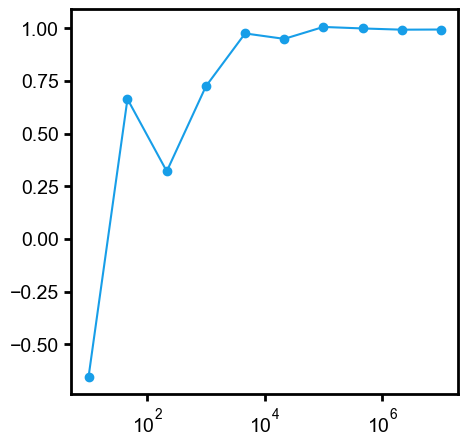

In [4]:
# Look at sample size dependence of estimate
nums_to_use = np.logspace(1, 7, 10, base=10).astype(int)
mis = []

for num_to_use in tqdm(nums_to_use):
    mi = estimate_2_point_1_point_mi(one_point_noiseless_pixels, two_point_noiseless_pixels, snr, num_measurements=num_to_use)
    mis.append(mi)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.semilogx(nums_to_use, mis, 'o-')

print(f"Estimated MI: {mi:.3f} bits")

## Estimate using pixelCNN

Adding noise: 100%|██████████| 977/977 [00:01<00:00, 869.52it/s]


Initial validation NLL: 6.85


Epoch 1: 100%|██████████| 100/100 [00:04<00:00, 20.04it/s]


Epoch 1: validation NLL: 3.96


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 137.22it/s]


Epoch 2: validation NLL: 3.96


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 142.20it/s]


Epoch 3: validation NLL: 3.95


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 141.14it/s]


Epoch 4: validation NLL: 3.95


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 150.53it/s]


Epoch 5: validation NLL: 3.94


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 148.56it/s]


Epoch 6: validation NLL: 3.94


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 141.48it/s]


Epoch 7: validation NLL: 3.94


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 135.11it/s]


Epoch 8: validation NLL: 3.95


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 137.45it/s]


Epoch 9: validation NLL: 3.94


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 137.39it/s]


Epoch 10: validation NLL: 3.95
Estimated H(Y|X) = 3.904 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.941 differential entropy/pixel
Estimated I(Y;X) = 0.053 bits/pixel
1.3227615


Generating PixelCNN samples: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]

Estimated MI: 1.3228 bits


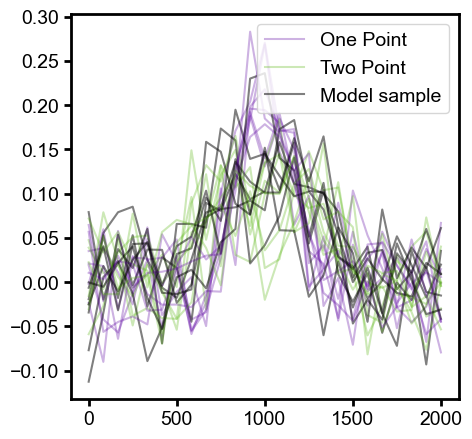

In [86]:

num_measurements = int(2e6)    

noisy_one_point_measurements = get_noisy_measurements(one_point_noiseless_pixels, snr, num_measurements // 2)
noisy_two_point_measurements = get_noisy_measurements(two_point_noiseless_pixels, snr, num_measurements // 2)

all_measurements = onp.concatenate([noisy_one_point_measurements, noisy_two_point_measurements])


mi, samples = pcnn_mi_estimate(all_measurements, snr, bias=40, scale=300, max_epochs=10, num_samples_to_return=10)
print(f'Estimated MI: {mi:.4f} bits')

# plot 5 noisy one point measurements, 5 noisy two point measurements, and 5 samples
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(8):
    ax.plot(np.linspace(0, size, num_pixels), noisy_one_point_measurements[i], color=get_color_cycle()[1], alpha=0.3)
    ax.plot(np.linspace(0, size, num_pixels), noisy_two_point_measurements[i],  color=get_color_cycle()[3], alpha=0.3)
    ax.plot(np.linspace(0, size, num_pixels), samples[i], color='k', alpha=0.5)
    # ax.plot(np.linspace(0, size, num_pixels), all_measurements[i], color='r', alpha=0.5)
ax.legend(['One Point', 'Two Point', 'Model sample'])

## Plot informaiton as a fucntion of SNR and NA



In [4]:
N_bins = 40

# SNRs = np.linspace(2, 0.1, 20)
SNRs = np.logspace(-2, 1, N_bins)
NAs = np.linspace(0.1, 1, N_bins) 

num_measurements = int(1e6)
# num_measurements = int(1e4)

wavelength = 400 # nm
pixel_size = 80 # nm
# size = 5000 # nm
size = 20000 # nm
num_pixels = int(size / pixel_size)
seperation_distance =  wavelength / (2 * 0.5) # rayleigh distance for NA = 0.5


results = onp.zeros((len(SNRs), len(NAs)))
for i, snr in tqdm(enumerate(SNRs), total=len(SNRs)):
    for j, na in enumerate(NAs):
        (one_point_object, two_point_object, one_point_convolved, two_point_convolved, one_point_noiseless_pixels, two_point_noiseless_pixels,
          x, PSF) = simulate_optics(wavelength, na, size, seperation_distance, pixel_size=pixel_size)
        mi = estimate_2_point_1_point_mi(one_point_noiseless_pixels, two_point_noiseless_pixels, snr, num_measurements=num_measurements)
        results[i, j] = mi

results = np.array(results)

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [1:36:41<00:00, 145.03s/it]


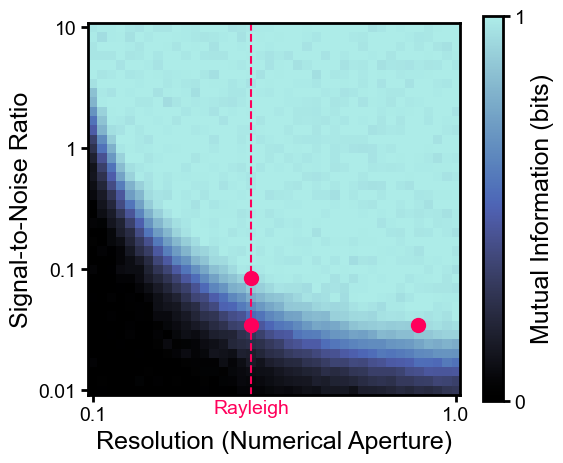

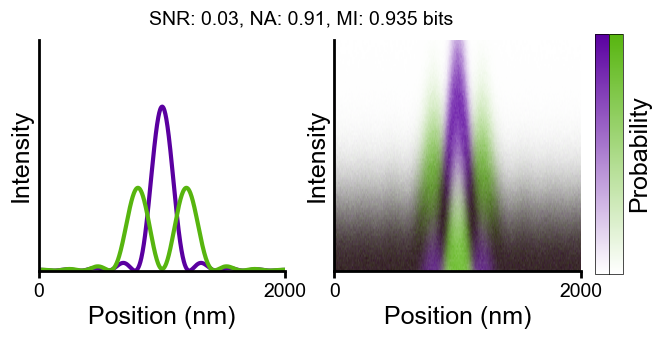

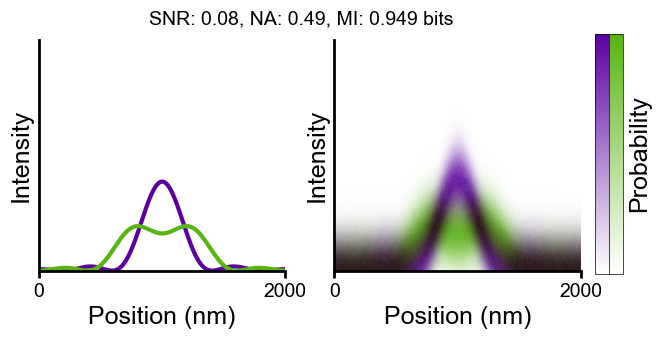

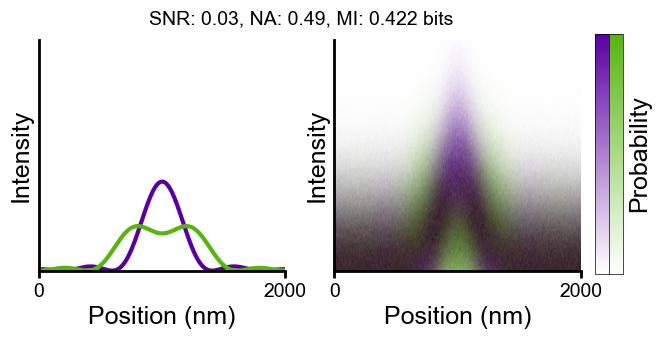

In [140]:
show_pixelated = False
num_noisy_measurements_to_display = 2
alpha = 0.25
show_extent = 2000
num_energy_coord_measurements = int(1e5)

# y_max = 0.6
y_max = 0.016


import cmasher as cmr
from matplotlib.ticker import LogLocator, LogFormatter

cmap = cmr.sapphire
red = get_color_cycle()[2]

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
cax = ax.imshow(results, cmap=cmap, origin='lower', vmin=0, vmax=1,)
            #      extent=[NAs[0], NAs[-1], SNRs[0], SNRs[-1]],
            # aspect= (NAs[-1] - NAs[0]) / (SNRs[-1] - SNRs[0]))
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('Mutual Information (bits)')
# set color bar labels to 0, 1
cbar.set_ticks([0, 1])

# make a ytick for every power of 10 in SNRs
ytick_labels = [ str(10**i) for i in range(int(np.log10(SNRs[0])), int(np.log10(SNRs[-1])) + 1)]

_ = ax.set(xlabel='Resolution (Numerical Aperture)', ylabel='Signal-to-Noise Ratio',
        xticks=[0, len(NAs) - 1], xticklabels=[NAs[0], NAs[-1]],
        yticks= np.linspace(0, len(SNRs) - 1, len(ytick_labels)), yticklabels=ytick_labels)


def add_point(SNR_value, NA_value):
        # Find the indices from the values, this is necessary for simulation and result extraction
        SNR_index = np.argmin(np.abs(SNRs - SNR_value))
        NA_index = np.argmin(np.abs(NAs - NA_value))

        # now replace the values with the ones we have data for
        SNR_value = SNRs[SNR_index]
        NA_value = NAs[NA_index]

        # Retrieve simulation details using indices if necessary
        (one_point_object, two_point_object, one_point_convolved, two_point_convolved, 
        one_point_noiseless_pixels, two_point_noiseless_pixels, x, PSF) = simulate_optics(wavelength, NA_value, size,
                                                                                        seperation_distance, pixel_size)
        
        # make_signal_and_measurement_plot(one_point_convolved, two_point_convolved, one_point_noiseless_pixels, 
        #                                 two_point_noiseless_pixels, x, SNR_value,
        #                                 show_pixelated=show_pixelated, num_measurements=num_noisy_measurements_to_display, alpha=alpha,
        #                                 energy_coord_pixel_indices=(one_point_noiseless_pixels.shape[-1] / 2 - (seperation_distance / 2 / pixel_size),
        #                                                             one_point_noiseless_pixels.shape[-1] / 2,),
        #                                                             num_energy_coord_noisy_measurements=num_energy_coord_measurements,
        #                                 y_max=y_max,
        #                                 show_extent=show_extent)
        


        plot_meaurement_sptial_distributions(x, one_point_convolved, two_point_convolved, SNR_value,  y_max, show_extent,
                                                hist_density_max=0.3,
                                                num_intensity_bins=100, num_measurements= int(1e4), )
                                        

        plt.gcf().suptitle(f"SNR: {SNR_value:.2f}, NA: {NA_value:.2f}, MI: {results[SNR_index, NA_index]:.3f} bits", fontsize=14)

        # Plot the point using the actual SNR and NA values
        ax.plot(NA_index, SNR_index, 'o', markersize=10, color=red)
        return results[SNR_index, NA_index]


def find_point_within_limits(mi_limits, na_limits):
        NA_grid, SNR_grid = np.meshgrid(NAs, SNRs)

        search_space = results.copy()
        
        if na_limits[0] is not None:
                search_space[NA_grid < na_limits[0]] = np.nan
        if na_limits[1] is not None:
                search_space[NA_grid > na_limits[1]] = np.nan
        
        if mi_limits[0] is not None:
                search_space[results < mi_limits[0]] = np.nan
        if mi_limits[1] is not None:
                search_space[results > mi_limits[1]] = np.nan

        # find the lowest SNR combo that meets the criteria
        SNR_grid[np.isnan(search_space)] = np.nan
        max_index = np.nanargmin(SNR_grid)
        max_index = np.unravel_index(max_index, search_space.shape)
        mi = add_point(SNR_value=SNRs[max_index[0]], NA_value=NAs[max_index[1]])
        return SNRs[max_index[0]], NAs[max_index[1]], mi


# compute NA that gives the Rayleigh distance for this seperation distance
rayleigh_na = wavelength / (2 * seperation_distance)
# make a dotted line at the Rayleigh NA
ax.axvline(np.argmin(np.abs(NAs - rayleigh_na)), color=red, linestyle='--')
# add label on the x axis
ax.text(np.argmin(np.abs(NAs - rayleigh_na)), -1, f'Rayleigh', color=red, ha='center', va='top')



### Find points to plot


snr1, na1, mi1 = find_point_within_limits(mi_limits=(0.9, 0.95), na_limits=(0.9, .95))
# plt.gcf().savefig('/home/hpinkard_waller/figures/1d_signals/' + f'2_point_representative_signals_1' + '.pdf', transparent=True)

snr2, na2, mi2 = find_point_within_limits(mi_limits=(0.9, 0.95), na_limits=(0.48, 0.51))
# plt.gcf().savefig('/home/hpinkard_waller/figures/1d_signals/' + f'2_point_representative_signals_2' + '.pdf', transparent=True)

mi3 = add_point(snr1, na2)
plt.gcf().savefig('/home/hpinkard_waller/figures/1d_signals/' + f'2_point_representative_signals_3' + '.pdf', transparent=True)


# fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + f'2_point_snr_resolution_info' + '.pdf', transparent=True)


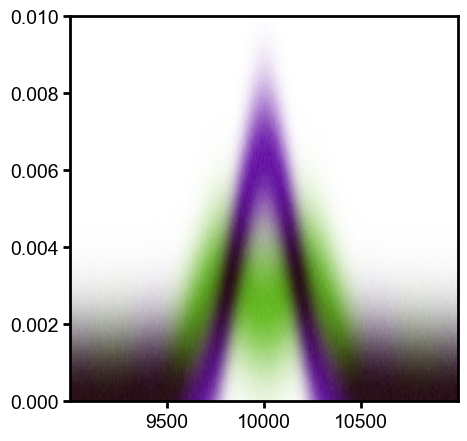

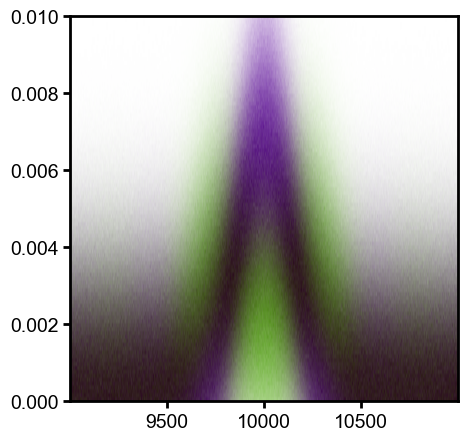

In [125]:
SNR_value = 0.1
NA_value = 0.5
num_measurements = int(3e4)
num_intensity_bins = 100
y_max = 0.01


# Retrieve simulation details using indices if necessary
(one_point_object, two_point_object, one_point_convolved, two_point_convolved, 
one_point_noiseless_pixels, two_point_noiseless_pixels, x, PSF) = simulate_optics(wavelength, NA_value, size,
                                                                                seperation_distance, pixel_size)



fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_meaurement_sptial_distributions(ax, x, one_point_convolved, two_point_convolved, SNR_value=0.1, y_max=0.01, show_extent=show_extent, num_measurements=num_measurements)



fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_meaurement_sptial_distributions(ax, x, one_point_convolved, two_point_convolved, SNR_value=0.05, y_max=0.01, show_extent=show_extent, num_measurements=num_measurements)


In [ ]:
')



# x = np.arange(num_pixels) * pixel_size
# # repeat for number of measurements
# x = np.tile(x, (num_measurements, 1))
# x = x.flatten()
# y_one_point = two_point_noisy_measurement.flatten()

# x_bins = np.linspace(x.min(), x.max(), num_pixels + 1)
# intensity_bins = np.linspace(0, y_max, num_intensity_bins)

# hist_counts = onp.histogram2d(x, y_one_point, bins=(x_bins, intensity_bins))[0].T

# # crop to center show_extent
# x_crop = np.argmin(np.abs(x - (extent / 2 - show_extent / 2)))
# hist_counts = hist_counts[:, x_crop:x_crop + int(show_extent / pixel_size)]


# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# ax.imshow(hist_counts, extent=(x.min(), x.max(), intensity_bins.min(), intensity_bins.max()), aspect='auto', cmap='inferno', 
#           origin='lower', interpolation='nearest')


In [64]:
num_pixels

250

In [60]:
hist_counts

array([], shape=(99, 0), dtype=float64)

In [ ]:
x += jax.random.normal(jax.random.PRNGKey(0), x.shape) 

y_one_point = one_point_noisy_measurement.flatten()

x_bins = np.linspace(x.min(), x.max(), num_pixels + 1)
intensity_bins = np.linspace(0, y_max, num_intensity_bins)

hist_counts = np.histogram2d(x, y_one_point, bins=(x_bins, intensity_bins))[0].T

# crop to center show_extent
x_crop = np.argmin(np.abs(x - (extent / 2 - show_extent / 2)))
hist_counts = hist_counts[:, x_crop:x_crop + int(show_extent / pixel_size)]


fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(hist_counts, extent=(x.min(), x.max(), intensity_bins.min(), intensity_bins.max()), aspect='auto', cmap='inferno', 
          origin='lower', interpolation='nearest')



# x = np.arange(num_pixels) * pixel_size
# # repeat for number of measurements
# x = np.tile(x, (num_measurements, 1))
# x = x.flatten()
# y_one_point = two_point_noisy_measurement.flatten()

# x_bins = np.linspace(x.min(), x.max(), num_pixels + 1)
# intensity_bins = np.linspace(0, y_max, num_intensity_bins)

# hist_counts = onp.histogram2d(x, y_one_point, bins=(x_bins, intensity_bins))[0].T

# # crop to center show_extent
# x_crop = np.argmin(np.abs(x - (extent / 2 - show_extent / 2)))
# hist_counts = hist_counts[:, x_crop:x_crop + int(show_extent / pixel_size)]


# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# ax.imshow(hist_counts, extent=(x.min(), x.max(), intensity_bins.min(), intensity_bins.max()), aspect='auto', cmap='inferno', 
#           origin='lower', interpolation='nearest')


In [55]:
hist_counts

array([], shape=(99, 0), dtype=float64)

In [33]:
x.shape

(8000,)

## Plot optimal classifier performance vs information

In [58]:
from scipy.stats import norm

def get_info_and_best_classifier(num_dimesnions, sigma, mean_difference, num_measurements=int(1e7)):
    """
    Assuming additive white Gaussian noise, both the informaiton content and the best classifier are known
    """
    normalized_difference = mean_difference / sigma
    # take normal cdf
    best_classifier_acc = norm.cdf(normalized_difference / 2)

    # Compute information
    means = [onp.zeros(num_dimesnions), onp.zeros(num_dimesnions)]
    means[1][0] = mean_difference
    covs = [np.eye(num_dimesnions) * sigma**2 for _ in means]
    weights = np.array([0.5, 0.5])

    hy_mid_x = (0.5 * np.log(2 * np.pi * np.e * sigma**2)) * num_pixels
    all_measurements = sigma * jax.random.normal(jax.random.PRNGKey(onp.random.randint(10000)), shape=(num_measurements, num_dimesnions))
    # shift half of the measurements by the mean difference along one dimension
    all_measurements = all_measurements.at[num_measurements // 2:, 0].set(all_measurements[num_measurements // 2:, 0] + mean_difference)

    h_y = gmm_mean_nll(all_measurements, means, covs, weights)

    mi = (h_y - hy_mid_x) / np.log(2) # convert to bits

    return  best_classifier_acc, mi
    

mean_diffs = np.linspace(0, 6, 60)
num_pixels = 32

best_accuracies = []
mis = []
for mean_diff in tqdm(mean_diffs):
    best_acc, mi = get_info_and_best_classifier(num_dimesnions=num_pixels, sigma=1, mean_difference=mean_diff)
    best_accuracies.append(best_acc)
    mis.append(mi)


100%|██████████| 60/60 [00:48<00:00,  1.24it/s]


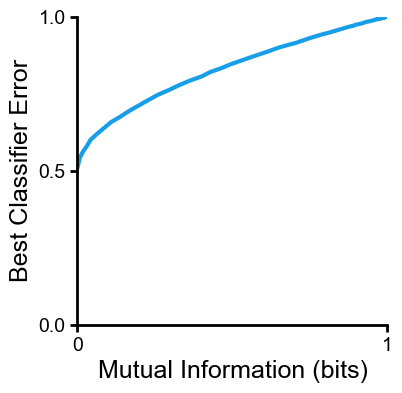

In [59]:

# scatter plot of MI vs best classifier error
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(mis, best_accuracies, '-', linewidth=3)
ax.set(xlabel='Mutual Information (bits)', ylabel='Best Classifier Error', xlim=(0, 1), ylim=(0, 1),
        xticks=[0, 1], yticks=[0, 0.5, 1])
clear_spines(ax)
fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + f'2_point_mi_vs_classifier_error' + '.pdf', transparent=True)

# # plot seperation dist vs MI
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# ax.plot(mean_diffs, mis, '-o')
# ax.set(xlabel='Mean Difference', ylabel='Mutual Information (bits)', xlim=(0, 6))
# clear_spines(ax)

# # plot seperation dist vs best classifier error
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# ax.plot(mean_diffs, best_accuracies, '-o')
# ax.set(xlabel='Mean Difference', ylabel='Best Classifier Error', xlim=(0, 6), ylim=(0, 1))
# clear_spines(ax)

## Compare information to information from random signals

In [98]:
from signal_utils_1D import generate_uniform_random_bandlimited_signals  

num_measurements = int(1e5)

wavelength = 400 # nm
NA = .5
# pixel_size = 40 # nm
nyq_pixel_size = nyquist_pixel_size(wavelength, NA) # in nanometers
pixel_size = nyq_pixel_size
size = 3200 # nm
usampled_signal_size = int(size // pixel_size)
num_nyquist_samples = int(size // nyq_pixel_size)
num_pixels = int(size / pixel_size)
seperation_distance = 400 # nm

one_point_object, two_point_object, one_point_convolved, two_point_convolved, \
      one_point_noiseless_pixels, two_point_noiseless_pixels, x, cropped_PSF = simulate_optics(wavelength, NA, size, seperation_distance, pixel_size)


uniformly_sampled_signals = generate_uniform_random_bandlimited_signals(num_nyquist_samples=num_nyquist_samples, 
                                                                            num_signals=num_measurements, upsampled_signal_length=usampled_signal_size)

Generating signals: 100096it [00:23, 4340.95it/s]                           


concatenating...


Generating signals:  13%|█▎        | 12544/100000 [02:31<17:39, 82.56it/s]  


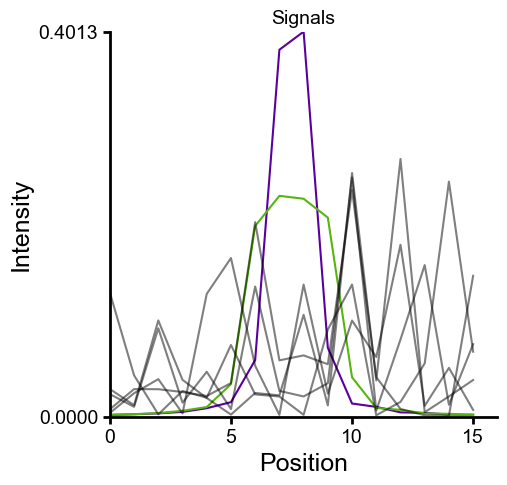

In [99]:
# plot the one point signal, the two point signal, and the first 5 uniformly sampled signals
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(one_point_noiseless_pixels, get_color_cycle()[1])
ax.plot(two_point_noiseless_pixels, get_color_cycle()[3])
for i in range(5):
    ax.plot(uniformly_sampled_signals[i], color='k', alpha=0.5)
_ = ax.set(title='Signals', xlim=(0, num_pixels), ylim=(0, one_point_noiseless_pixels.max()),
            yticks=[0, one_point_noiseless_pixels.max()], xlabel='Position', ylabel='Intensity')
clear_spines(ax)

Adding noise: 100%|██████████| 98/98 [00:00<00:00, 458.53it/s]


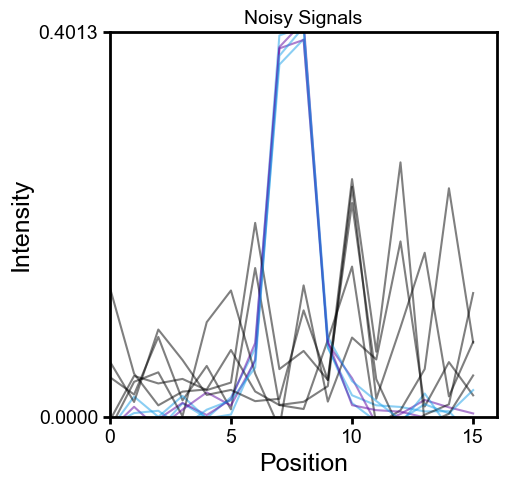

In [124]:
# generate noisy versions
from resolution1d_utils import pcnn_mi_estimate

snr = 5
gaussian_noise_sigma = 1 / (snr * one_point_noiseless_pixels.size)

noisy_one_point_measurements = get_noisy_measurements(one_point_noiseless_pixels, snr, num_measurements // 2)
noisy_two_point_measurements = get_noisy_measurements(two_point_noiseless_pixels, snr, num_measurements // 2)

noisy_object_measurements = np.concatenate([noisy_one_point_measurements, noisy_two_point_measurements])

noisy_uniformly_sampled_signals = get_noisy_measurements(uniformly_sampled_signals, snr, num_measurements)

# plot some example noisy signals vs noisy object measurements
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(5):
    ax.plot(noisy_object_measurements[i], color=get_color_cycle()[i % 2], alpha=0.5)
    ax.plot(noisy_uniformly_sampled_signals[i], color='k', alpha=0.5)   
_ = ax.set(title='Noisy Signals', xlim=(0, num_pixels), ylim=(0, one_point_noiseless_pixels.max()),
            yticks=[0, one_point_noiseless_pixels.max()], xlabel='Position', ylabel='Intensity')

In [125]:
mi_object, samples_object = pcnn_mi_estimate(noisy_object_measurements, snr, max_epochs=10, num_samples_to_return=10, bias=200, scale=300)
mi_uniform, samples_uniform = pcnn_mi_estimate(noisy_uniformly_sampled_signals, snr, max_epochs=10, num_samples_to_return=10, bias=200, scale=300)

print(f'Estimated MI for object: {mi_object:.4f} bits')
print(f'Estimated MI for uniformly sampled signals: {mi_uniform:.4f} bits')
# print ratio of MI
print(f'Ratio of MI: {mi_uniform /  mi_object:.4f}')

Initial validation NLL: 5.22


Epoch 1: 100%|██████████| 100/100 [00:05<00:00, 18.56it/s]


Epoch 1: validation NLL: 2.80


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 115.62it/s]


Epoch 2: validation NLL: 2.79


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 116.62it/s]


Epoch 3: validation NLL: 2.79


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 116.54it/s]


Epoch 4: validation NLL: 2.78


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 113.82it/s]


Epoch 5: validation NLL: 2.80


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 116.78it/s]


Epoch 6: validation NLL: 2.78


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 110.88it/s]


Epoch 7: validation NLL: 2.78


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 115.28it/s]


Epoch 8: validation NLL: 2.78


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 118.09it/s]


Epoch 9: validation NLL: 2.78


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 121.49it/s]


Epoch 10: validation NLL: 2.78
Estimated H(Y|X) = 2.741 differential entropy/pixel
Estimated H(Y) (Upper bound) = 2.791 differential entropy/pixel
Estimated I(Y;X) = 0.073 bits/pixel
1.1677264


Generating PixelCNN samples: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Initial validation NLL: 5.59


Epoch 1: 100%|██████████| 100/100 [00:05<00:00, 18.39it/s]


Epoch 1: validation NLL: 4.02


Epoch 2: 100%|██████████| 100/100 [00:00<00:00, 121.11it/s]


Epoch 2: validation NLL: 4.03


Epoch 3: 100%|██████████| 100/100 [00:00<00:00, 120.35it/s]


Epoch 3: validation NLL: 4.01


Epoch 4: 100%|██████████| 100/100 [00:00<00:00, 118.03it/s]


Epoch 4: validation NLL: 4.02


Epoch 5: 100%|██████████| 100/100 [00:00<00:00, 115.23it/s]


Epoch 5: validation NLL: 4.01


Epoch 6: 100%|██████████| 100/100 [00:00<00:00, 121.34it/s]


Epoch 6: validation NLL: 4.02


Epoch 7: 100%|██████████| 100/100 [00:00<00:00, 120.99it/s]


Epoch 7: validation NLL: 4.01


Epoch 8: 100%|██████████| 100/100 [00:00<00:00, 124.08it/s]


Epoch 8: validation NLL: 4.01


Epoch 9: 100%|██████████| 100/100 [00:00<00:00, 125.53it/s]


Epoch 9: validation NLL: 4.01


Epoch 10: 100%|██████████| 100/100 [00:00<00:00, 123.02it/s]


Epoch 10: validation NLL: 4.02
Estimated H(Y|X) = 2.741 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.012 differential entropy/pixel
Estimated I(Y;X) = 1.833 bits/pixel
29.335512


Generating PixelCNN samples: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]

Estimated MI for object: 1.1677 bits
Estimated MI for uniformly sampled signals: 29.3355 bits
Ratio of MI: 25.1219
